In [1]:
import pandas as pd
import script_reglas

import nltk as nltk
from emoji import UNICODE_EMOJI
import unicodedata as unicodedata
import re
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

[NbConvertApp] Converting notebook script_reglas.ipynb to script
[NbConvertApp] Writing 4484 bytes to script_reglas.py


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
respuestas=pd.read_excel('s3://presidencia-mi-salud/processed/results_export_964.xlsx', encoding='utf-8')

In [3]:
respuestas=respuestas[['Contact UUID', 'URN', 'Name', 'Groups', 'Response 9 (Text) - uncaught']]
respuestas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'texto']

In [4]:
categoria_reglas=pd.DataFrame()
for i in range(0, respuestas.shape[0]):
    respuesta_regla=pd.DataFrame(script_reglas.procesa_reglas(str(respuestas['texto'].iloc[i])), index=[i])
    categoria_reglas=pd.concat([categoria_reglas, respuesta_regla])
respuestas=pd.concat([respuestas[['id_contacto', 'urn', 'nombre_contacto', 'listas']],
                      categoria_reglas], axis=1)

In [5]:
print(respuestas.shape)
respuestas=respuestas.loc[respuestas.texto!='nan']
print(respuestas.shape)

(3045, 9)
(2472, 9)


In [6]:
respuestas.result.value_counts()

modelo           970
like-fb          480
si               309
gracias          184
hola             136
no               114
informacion      100
ok                95
emoji             36
spam              23
twitter-image     13
hasta luego        6
pregunta           4
aborto             2
Name: result, dtype: int64

In [7]:
etiquetado=pd.read_csv('s3://presidencia-mi-salud/processed/clasificacion_misalud.csv')

In [8]:
respuestas_etiquetas=pd.merge(respuestas, etiquetado[['id_contacto', 'categ_opi', 'Clasificacion final']],how='left',
                              on=['id_contacto'])
print(respuestas_etiquetas.shape)

(2472, 11)


In [9]:
respuestas_etiquetas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'cc', 'result',
       'texto', 'texto_proc', 'wc', 'categ_opi', 'categ_final']

In [10]:
respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.result=='modelo']

In [11]:
respuestas_etiquetas.categ_final.loc[respuestas_etiquetas.categ_final.isnull()]=respuestas_etiquetas.categ_opi.loc[respuestas_etiquetas.categ_final.isnull()]

In [12]:
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.categ_final=='cancelar')]='respuesta'
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.categ_final=='otra_registro')]='otra'


/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
respuestas_etiquetas.categ_final.value_counts()

pregunta                  337
otra                      278
otra_queja                145
respuesta                  76
pregunta_busca trabajo     58
informacion                44
pregunta_medica            18
emergencia                  7
nacimiento                  7
Name: categ_final, dtype: int64

In [14]:
respuestas_etiquetas.head()

,id_contacto,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra
10,313822ff-7541-4db6-8fe1-a252363000ab,+522461582793,sarahi,"ALL, ALTOPD",135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra
16,86962a26-c021-4606-8986-893834ad83bd,+524271210385,NaN,"ALL, ALTOPD",5,modelo,59508,59508,1,respuesta,informacion
17,84b7624f-261d-44b4-83ba-6fade1a44c3a,+524271654479,NaN,"ALL, ALTOPD",7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento
29,e083b2ea-6e2d-410c-b5a4-8067a818d485,+522411259330,NaN,"ALL, ALTOPD",99,modelo,Hola si ya cada integrante tenemos fotos con l...,hola si ya cada integrante tenemos fotos con l...,18,nacimiento,respuesta


In [15]:
respuestas_etiquetas.categ_final.loc[(respuestas_etiquetas.texto=='¿Cómo saben que estoy triste?')]='otra'


/home/pepe/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
respuestas_etiquetas.shape

(970, 11)

In [17]:
#Quitar esto de entrenamiento (sin regla)
respuestas_etiquetas=respuestas_etiquetas.loc[~respuestas_etiquetas.texto_proc.str.contains('alpura')]

In [18]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(['201b66a2-d3b7-4d8e-9785-925fae418b9f']),
                         'categ_final']='otra'

In [19]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin([ "315e4a0e-5692-458b-9a34-edda1d59dfaa", "07d91f23-956e-4137-9cb9-0ad37eece884",
 "0c4185c6-cbde-45b8-bfc2-883bf541ac70", "730fcec0-42c5-4d3b-8930-ab51107b3481",
 "f13234ba-8f0f-41d3-bb4b-e881d661d5d0", "445fc418-8dee-4093-8ce5-b422012a8c29",
 "ad32e3f4-3de6-4ee3-917d-c5bc67311ebb", "6164a0da-09b0-4f49-8682-09f7ebf19a57"]), 'categ_final']='pregunta'

In [20]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["7aa2610b-3d10-45d0-9411-f23a58d5e7f6",
                                                                "0fe6bb9f-61a3-42e1-a24b-d96ad87e7a14",
"742515b1-34c7-4717-9783-dc3f3551582a", "375255c7-6488-4421-8c9b-e9f782c02177",
"c29fdc4c-5d90-488e-aa1a-2bc42ad9dc10", "f5b13bcb-c497-4202-94a3-3740e1e40ebb",
"11609c48-7f69-49b7-935f-a455f81cc689", "48c3fc35-9f63-4a68-93a3-5bb2ba63abf2",
"e4dfc00a-aee2-47e2-8903-f41b9f389bbe", "3e30ad64-98a0-4fa7-89d5-6bdbb1d5c4aa",
"30c71f56-5efe-4ada-b441-8845e045dc48", "2c4ec370-9ae3-4341-8010-da99f47ac6c7",
"8c161d31-0c11-4acc-a8cf-b29fd929834e", "ff5b1588-5de4-4341-aeba-3cedc17edc11",
"3501230e-3630-42af-8c87-3c38c501ce31", "3b663449-9eae-400b-aed4-1090eefb3ffa",
"3ca561ed-e602-4e02-9bae-a1fb8f49275e", "9513a679-359c-4fb1-84de-a47ee7da37e9",
"a48f38c8-a6ba-4687-81ea-8acf0bcc258e", "fe969b27-9304-47fc-b83a-43a68ef89a7c",
"c0120e21-da75-4c01-a2bb-de34efe20bbb", "eb7135f3-b7d7-4eb1-87d9-c23589185e79",
"05c09608-cb3d-43a4-9180-c01eef664d73", "947bc0cc-6e23-4ae6-ba87-5bff47265051",
"89c67cdd-869e-4886-8962-0fbb7f527c77", "55d6b8f7-519e-407b-a6ae-c0e612fc5f9e",
"3dd510fc-4400-47c6-aceb-e428d440e2e8", "2d1fceea-5186-417d-a305-0bfc4135f1a6",
"5435b6eb-157f-450a-9f19-b9bdc79d1000", "5d75d608-1371-43be-9ae2-77d2cae4e147",
"72da582b-61a2-4a55-9b5d-2ce3bc9675be", "12793eee-3d8d-4bb9-b730-3224f73c7dd7",
"14ed5c51-c6b0-4006-93d8-397430ed0604", "d2a22a42-1f0f-4ace-85f2-31ca5df1b9c2"]), 'categ_final']='pregunta'

In [21]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["3c3bd7db-9a80-4a5e-8dc7-57d5565c29a7",
                                                                "56f71659-a4cb-49e2-95d3-305ecb4bd8ca"]), 'categ_opi']='emergencia'

In [22]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["6d0c0722-1c83-44e0-b6db-48ed738f7a15",
                                                           "6620e386-b489-4fb7-90a6-1ea1f5d93214",
                                                           "09c68677-1a0b-4822-b6ca-ceac5bd1da46",
                                                           "51ea4f55-2e1b-4c74-859a-2a1fcbbca375",
                                                           "5ba8ce97-ac5c-4323-8f88-ce4b0d5fb589",
                                                           "1636e26b-f6b4-412a-b8bb-5376591e7a4e",
                                                           "79a55871-5622-46b3-b97c-554f47066fc8",
                                                           "415bfebd-3303-4e9a-9628-9d1d10f67be0","3777c4a4-474f-4949-a180-dfd8066445cc",
                                                           "2dcc713e-5fcc-4604-9dad-f6f412c0993f",
                                                           "f51c0616-a092-4448-98b9-85ba13eb7556"]), 'categ_final']='informacion'

In [23]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["d766cbce-0639-4bd8-9415-310259a5e3b0",
                                                                "2ea485d9-8ad5-42f5-aac4-335d30d6db51",
                                                                "c7599cd7-1f2f-492c-a9e8-1a8df001166a",
                                                                "1821255c-4661-426b-9c05-9b8f1074aa14",
                                                                "2b0cda19-29f8-4e62-9949-c771f35911ba",
                                                                "84e98ae0-fa1c-4af2-9c7d-95059691f5b1",
                                                                "355ae44c-d55d-443e-b0b3-c27de87b84cf",
                                                                "50670170-59c4-4f4b-a75e-c5c4e9c7a9f5",
                                                                "e90f2991-3315-47e6-9053-8d5fcf12335c",
                                                                "e7b6e3ac-3f26-47ed-92ec-7e29be2c923f",
                                                                "1cba7fb9-727a-4168-a20e-367e437d8906",
                                                                "16f41986-74d6-4e40-8eee-2f96d2379a3d",
                                                                "368c48b6-52e5-449e-8b61-e46f4bbfee99",
                                                                "813a073e-43ed-40fa-a7a5-85c71f8f4e10",
                                                                "9a6b4089-f2eb-4364-923d-81faa4e2bb33",
                                                                "5bbc9aea-e206-4121-b701-11569503d3e0",
                                                                "99dcc06f-0710-4f66-b3ba-b3e2c7231df1",
                                                                "899da69b-0ba7-40d1-9ef1-fc7df04f6954"]), 'categ_final']='informacion'

In [24]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["79b5b59a-c337-4db3-88b9-eebdd6c58b31",
                                                                "e58e3969-5092-4e62-acd9-82a5c5f334d8"]), 'categ_final']='otra'

In [25]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["4866bd81-0b21-4bbb-b071-d857dc27823a",
                                                                "f8df8fa0-9032-4dc8-aaed-990e7644d00a",
                                                                "26fc8fc3-43f1-4ea8-9f0b-69627c5bf548"]), 'categ_final']='emergencia'

In [26]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["e4badd90-126e-429d-aa04-2f536093b9fd",
                                                                "bda3f149-2f40-4575-8d6e-b9f2237370a0"]), 'categ_final']='respuesta'

In [27]:
respuestas_etiquetas.loc[respuestas_etiquetas.id_contacto.isin(["4f6a4c5b-f355-4ef1-9e78-33b7cdf41603"]),
                         'categ_final']='otra'

In [28]:
print(pd.factorize(respuestas_etiquetas.categ_final)[1])
map_fac=pd.factorize(respuestas_etiquetas.categ_final)[1]
respuestas_etiquetas.categ_opi=pd.factorize(respuestas_etiquetas.categ_final)[0]

Index(['otra', 'informacion', 'nacimiento', 'respuesta', 'emergencia',
       'pregunta', 'pregunta_busca trabajo', 'otra_queja', 'pregunta_medica'],
      dtype='object')


In [29]:
pd.crosstab(respuestas_etiquetas.categ_opi,respuestas_etiquetas.categ_final) 

categ_final,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
categ_opi,,,,,,,,,
0,0,0,0,229,0,0,0,0,0
1,0,64,0,0,0,0,0,0,0
2,0,0,7,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,77
4,9,0,0,0,0,0,0,0,0
5,0,0,0,0,0,356,0,0,0
6,0,0,0,0,0,0,58,0,0
7,0,0,0,0,136,0,0,0,0
8,0,0,0,0,0,0,0,15,0


In [30]:



label_map={0:'otra',
          1:'informacion',
          2: 'nacimiento',
          3: 'respuesta',
          4: 'emergencia',
          5: 'pregunta',
          6: 'pregunta_busca trabajo',
          7: 'otra_queja',
          8: 'pregunta_medica'}

respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_opi.map(label_map)

In [31]:
respuestas_etiquetas.head()

,id_contacto,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra
10,313822ff-7541-4db6-8fe1-a252363000ab,+522461582793,sarahi,"ALL, ALTOPD",135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra
16,86962a26-c021-4606-8986-893834ad83bd,+524271210385,NaN,"ALL, ALTOPD",5,modelo,59508,59508,1,informacion,informacion
17,84b7624f-261d-44b4-83ba-6fade1a44c3a,+524271654479,NaN,"ALL, ALTOPD",7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento
29,e083b2ea-6e2d-410c-b5a4-8067a818d485,+522411259330,NaN,"ALL, ALTOPD",99,modelo,Hola si ya cada integrante tenemos fotos con l...,hola si ya cada integrante tenemos fotos con l...,18,respuesta,respuesta


## preprocesamiento

In [32]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto'].str.lower()

 ### Quitar leading y trailing spaces, quitar puntuacion

In [33]:
respuestas_etiquetas.shape

(951, 11)

In [34]:

texto=respuestas_etiquetas.texto_proc.values
for i in range(0, respuestas_etiquetas.shape[0]):
    part=texto[i].partition('http')
    part=part[0]+part[1]+' '+ ' '.join(part[2].split(' ')[1:])
    texto[i]=part
    

In [35]:
for i in range(0, respuestas_etiquetas.shape[0]):
    part=texto[i].partition('bit.ly')
    part=part[0]+part[1]+' '+ ' '.join(part[2].split(' ')[1:])
    texto[i]=part

In [36]:
respuestas_etiquetas.texto_proc=texto

In [37]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

In [38]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['texto_proc'].str.count('\\?')>0

In [39]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.replace('[^\w\s]','')

In [40]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

### Capturar emojis

In [41]:
es_emoji=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    es=pd.DataFrame({'es':script_reglas.is_emoji(respuestas_etiquetas['texto'].iloc[i])}, index=[0])
    es_emoji=pd.concat([es_emoji, es], ignore_index=True)
print(es_emoji.shape[0]==respuestas_etiquetas.shape[0])

True


In [42]:
respuestas_etiquetas=respuestas_etiquetas.reset_index(drop=True)

In [43]:
respuestas_etiquetas=pd.concat([respuestas_etiquetas, es_emoji], axis=1)

### Quitar emojis que quedan en el texto

In [44]:
sinemojis=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinemojis_i=script_reglas.give_emoji_free_text(respuestas_etiquetas.texto_proc.iloc[i])
    sinemojis_i=pd.DataFrame({'texto':sinemojis_i}, index=[i])
    sinemojis=pd.concat([sinemojis, sinemojis_i])
respuestas_etiquetas['texto_proc']=sinemojis

### Quitar  acentos

In [45]:
sinacentos=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinacentos_i=unicodedata.normalize('NFD', respuestas_etiquetas['texto_proc'].iloc[i]).encode('ascii', 'ignore').decode('utf-8')
    sinacentos_i=pd.DataFrame({'texto':sinacentos_i}, index=[i])
    sinacentos=pd.concat([sinacentos, sinacentos_i])
respuestas_etiquetas['texto_proc']=sinacentos

In [46]:
respuestas_etiquetas.texto_proc=respuestas_etiquetas.texto_proc.str.replace('ola|buena noche|buenos dias|buenos dia|buen dia|buenas noches|buenas tardes|buenas tarde|buen dia|bien dia|buena tardes|buena tarde|saludos|hola', '')

In [47]:
respuestas_etiquetas.texto_proc=respuestas_etiquetas.texto_proc.str.replace('\n', ' ')

### Procesar dummy de  listas

In [48]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

In [49]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

prueba_listas=respuestas_etiquetas.listas.str.split(expand=True)
lista=[pd.get_dummies(prueba_listas[col]) for col in prueba_listas]

for i in range(0, len(lista)):
    lista[i]['indice'] = lista[i].index
lista=pd.concat(lista, ignore_index=True)
prueba_listas=lista.groupby('indice', as_index=True).agg('sum')

Eliminar listas con pocas personas

In [50]:
prueba_listas=prueba_listas[prueba_listas.sum()[~(prueba_listas.sum()<=3)].keys()]

### TF-DF

In [51]:
stop=nltk.corpus.stopwords.words("spanish")

In [52]:
for i in range(0, np.shape(stop)[0]):
    stop[i]=unicodedata.normalize('NFD', stop[i]).encode('ascii', 'ignore').decode('utf-8')

In [53]:
stemmer = SnowballStemmer("spanish")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [54]:
stemmed=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    stemmed_i=' '.join(tokenize_and_stem(respuestas_etiquetas.texto_proc[i]))
    stemmed_i=pd.DataFrame({'texto':stemmed_i}, index=[i])
    stemmed=pd.concat([stemmed, stemmed_i])
respuestas_etiquetas['texto_proc_stem']=stemmed

In [55]:
#respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.texto_proc.ravel()!='']

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.006, norm='l2', encoding='utf-8', ngram_range=([1, 1]),
                        stop_words=stop)
features = tfidf.fit_transform(respuestas_etiquetas.texto_proc)
labels = respuestas_etiquetas.categ_opi
features.shape

(951, 328)

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.006, norm='l2', encoding='utf-8', ngram_range=([1, 2]),
                        stop_words=stop)
features_stem = tfidf.fit_transform(respuestas_etiquetas.texto_proc_stem)
labels = respuestas_etiquetas.categ_final
features_stem.shape

(951, 466)

In [58]:
x_target=respuestas_etiquetas.categ_opi
x_train=respuestas_etiquetas.texto_proc_stem

In [59]:
totalvocab_stemmed = []
totalvocab_tokenized = []
lista_fin=list()
for i in x_train:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [60]:
respuestas_etiquetas.head()

,id_contacto,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra,False,0,la solicitud de envi el sms por cobr a ha expi...
1,313822ff-7541-4db6-8fe1-a252363000ab,+522461582793,sarahi,all altopd,135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra,False,0,te llam y no pud localizart tramit en line tu ...
2,86962a26-c021-4606-8986-893834ad83bd,+524271210385,NaN,all altopd,5,modelo,59508,59508,1,informacion,informacion,False,0,
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,+524271654479,NaN,all altopd,7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento,False,0,mi beb
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,+522411259330,NaN,all altopd,99,modelo,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,18,respuesta,respuesta,False,0,si ya cad integr ten fot con la bb segu nos to...


In [61]:
from sklearn.feature_selection import chi2

N = 5
for category_id in sorted(respuestas_etiquetas.categ_opi.unique()):
  features_chi2 = chi2(features_stem, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(category_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
 # print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'emergencia':
  . Most correlated unigrams:
. present
. dolor
. urgenci
. riesg
. cirugi
  . Most correlated bigrams:
. pued acud
. apoy par
. esper respuest
. hospital general
. hac par
# 'informacion':
  . Most correlated unigrams:
. algui
. comunicacion
. vacun
. telefon
. extension
  . Most correlated bigrams:
. vacun contr
. vacun hepatitis
. numer telefon
. algun numer
. podri proporcion
# 'nacimiento':
  . Most correlated unigrams:
. vacun
. salud
. pued
. par
. beb
  . Most correlated bigrams:
. centr salud
. vacun hepatitis
. quis sab
. secretari salud
. dond pued
# 'otra':
  . Most correlated unigrams:
. dond
. credit
. mensaj
. sms
. http
  . Most correlated bigrams:
. quis sab
. teng problem
. segur popul
. envi mensaj
. dond pued
# 'otra_queja':
  . Most correlated unigrams:
. vend
. call
. denunci
. vecin
. report
  . Most correlated bigrams:
. pued hac
. asi com
. sol par
. vecin tien
. pued report
# 'pregunta':
  . Most correlated unigrams:
. segur
. campan
. dond
. p

### Pruebas número de factores

In [62]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_predict
#import umap
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(context='notebook', style='white', rc={'figure.figsize':(20,20)})


In [63]:
labs=x_target.factorize()[1]
x_target=x_target.factorize()[0]

In [64]:
def loo(i, a):
    features_i=features_stem[i].toarray()
    features_menos_i=np.delete(features_stem.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    pca=pca.fit(features_menos_i)
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    Xall=pd.DataFrame(features_menos_i)
    clasificador=RandomForestClassifier()
    loo_predict_proba=pd.DataFrame()
    X_i=pd.DataFrame(features_i)
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    clasificador=XGBClassifier()
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out[0].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                      pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                     ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [65]:
from datetime import datetime

In [70]:
loo_predict_proba.columns

Index([    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es', 'texto_proc_stem',                 0,
                       0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8],
      dtype='object')

In [80]:
precision=pd.DataFrame()

for a in range(5, 100):
    inicio=datetime.now()
    loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo)(i, a) for i in respuestas_etiquetas.index)

    fin=datetime.now()

    loo_predict_proba=pd.concat(loo_predict_proba)

    loo_predict_proba.columns=[    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es', 'texto_proc_stem',        'pred_loo',
                       0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8]

    precision_i=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='micro')
    print(str(a)+ '\n')
    precision_i=pd.DataFrame({'precision':precision_i,
                  'tiempo_entrenamiento':(fin-inicio),'n_loadings':a}, index=[a])
    precision=pd.concat([precision, precision_i],)
    precision.to_csv('precision_loadings.csv')
    print(precision_i)

KeyboardInterrupt: 

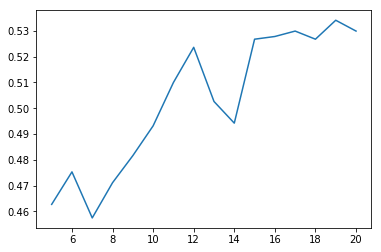

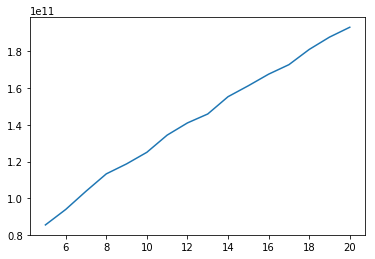

In [77]:
plt.plot(precision.n_loadings, precision.precision)
plt.show()
plt.plot(precision.n_loadings, precision.tiempo_entrenamiento)
plt.show()

In [82]:
pca=TruncatedSVD(n_components=33)
Xall=pca.fit_transform(features_stem)
Xall=pd.DataFrame(Xall)

inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo)(i, 33) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

   # print(str(i)+ ' ' +
   #       loo_predict_proba_i[[0, 1, 2, 3, 4, 5, 6, 7, 8]].idxmax(axis=1).astype(str)[i]+ ' ' +
   #       loo_predict_proba_i.categ_final.astype(str)[i] + ' '+loo_predict_proba_i.texto.astype(str)[i])

0:05:06.761080


In [83]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [84]:
loo_predict_proba.columns

Index([    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es', 'texto_proc_stem',                 0,
                       0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8],
      dtype='object')

In [85]:
loo_predict_proba.columns=[    'id_contacto',             'urn', 'nombre_contacto',
                'listas',              'cc',          'result',
                 'texto',      'texto_proc',              'wc',
             'categ_opi',     'categ_final', 'n_interrogacion',
                    'es', 'texto_proc_stem',        'pred_loo',
                       0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8]

(loo_predict_proba['pred_loo']==x_target).mean()


0.5783385909568874

In [86]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='macro')
print(precision)

0.41776300259270477


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [87]:
pd.crosstab(loo_predict_proba['pred_loo'], x_target)

col_0,0,1,2,3,4,5,6,7,8
pred_loo,,,,,,,,,
0,108,12,0,12,3,36,7,35,1
1,5,7,0,1,0,5,0,2,0
2,0,0,6,0,1,0,0,0,0
3,44,4,1,59,0,6,0,3,0
4,0,0,0,0,0,1,0,0,0
5,50,37,0,3,2,293,30,36,14
6,1,0,0,0,0,6,18,1,0
7,21,4,0,2,3,9,3,59,0


In [88]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['n_interrogacion'].astype(int)

### FEATURES DE FLUJOS

In [66]:
flujos=pd.read_csv('s3://presidencia-mi-salud/processed/flujos_peticiones.csv')

In [67]:
flujos.head()

,Unnamed: 0,contact_uuid,flujo_penultimo,flujo_ultimo,nombre,penultimo_tmstmp,texto,ultimo_tmstmp
0,0,3bf0c4bb-d5db-4e0d-ab29-98a7ee6b2b6a,b_consejo_w22_d3,b_development_w22_d4,NaN,2018-08-07T16:02:20.331086Z,NaN,2018-08-08T14:10:16.479863Z
1,1,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,NaN,2018-03-23T18:14:42.214452Z,La solicitud de enviar el SMS por Cobrar a 552...,2018-03-23T18:14:42.955021Z
2,2,7ea8e04b-e8d0-4628-bf35-350a784d5e2f,Fin_SMS,prueba_fb,pedro vallejo,2018-05-17T18:31:38.123141Z,🙅,2018-06-19T18:32:13.198465Z
3,3,3059e012-6fd3-445d-8da4-5fc36d45f8dc,b_concerns_w4_d4,cancelar_misalud,NaN,2018-03-02T15:01:46.787861Z,NaN,2018-03-02T16:25:41.512518Z
4,4,42bf4e3f-a396-4eb7-a987-b76cba779e92,b_nutrition_w78_d4,prueba_fb,Rosy,2018-06-18T14:00:10.181403Z,Hola gordo,2018-06-19T18:32:13.198465Z


In [68]:

flujos=flujos[['contact_uuid', 'flujo_penultimo', 'flujo_ultimo', 'ultimo_tmstmp','penultimo_tmstmp' ]]

In [69]:
flujos.ultimo_tmstmp=flujos.ultimo_tmstmp.str.replace('Z|T', ' ')
flujos.penultimo_tmstmp=flujos.penultimo_tmstmp.str.replace('Z|T', ' ')

flujos.penultimo_tmstmp=flujos.penultimo_tmstmp.str.strip()
flujos.ultimo_tmstmp=flujos.ultimo_tmstmp.str.strip()
from datetime import datetime
for i in range(0, flujos.shape[0]):
    if  (flujos.ultimo_tmstmp[i] is np.nan) == False:
        flujos.ultimo_tmstmp[i]=datetime.strptime(flujos.ultimo_tmstmp[i],
                  "%Y-%m-%d %H:%M:%S.%f")
    else: 
        flujos.ultimo_tmstmp[i]=None
    if  (flujos.penultimo_tmstmp[i] is np.nan) == False:
        flujos.penultimo_tmstmp[i]=datetime.strptime(flujos.penultimo_tmstmp[i],
                  "%Y-%m-%d %H:%M:%S.%f")
    else: 
        flujos.penultimo_tmstmp[i]=None

In [70]:
flujos['delta']=flujos.ultimo_tmstmp-flujos.penultimo_tmstmp


In [71]:
delta_horas=pd.DataFrame()
for i in range(0, flujos.shape[0]):
    dias=flujos.delta[i].days
    dias=dias*24
    horas=dias+flujos.delta[i].seconds/3600
    horas=pd.DataFrame({'delta_horas':horas}, index=[i])
    delta_horas=pd.concat([delta_horas, horas])
    

In [72]:
flujos=pd.concat([flujos, delta_horas], axis=1)

In [73]:
horas_ultimos=pd.DataFrame()
for i in range(0, flujos.shape[0]):
    hora_ultimo=int(flujos.ultimo_tmstmp[i].strftime('%H'))
    hora_ultimo=pd.DataFrame({'hora_ultimo':hora_ultimo}, index=[i])
    horas_ultimos=pd.concat([horas_ultimos, hora_ultimo])
flujos=pd.concat([flujos, horas_ultimos], axis=1)   

In [74]:
flujos=flujos[['contact_uuid', 'flujo_penultimo','flujo_ultimo', 'delta_horas', 'hora_ultimo']]
flujos.columns=['id_contacto', 'flujo_penultimo','flujo_ultimo', 'delta_horas', 'hora_ultimo']

In [75]:
respuestas_etiquetas=pd.merge(flujos, respuestas_etiquetas, how='inner',on='id_contacto' )

In [76]:
def loo_masvar(i, a, df_extra):
    df_extra_orig=df_extra
    features_i=features_stem[i].toarray()
    features_menos_i=np.delete(features_stem.toarray(), (i), axis=0)
    pca=TruncatedSVD(n_components=a)
    pca=pca.fit(features_menos_i)
    features_i=pca.transform(features_i)
    features_menos_i=pca.transform(features_menos_i)
    features_i=pd.concat([pd.DataFrame(features_i, index=[i]),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=pd.DataFrame(features_menos_i)
    
    
    
    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i).reset_index(drop=True))],axis=1)
    loo_predict_proba=pd.DataFrame()

    features_i.head()
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i)
    clasificador=XGBClassifier(metrics='auc')
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out[0].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [77]:
#respuestas_etiquetas=pd.concat([prueba_listas,
#           respuestas_etiquetas], axis=1)

In [78]:
respuestas_etiquetas.head()

,id_contacto,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,0.000000,18,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra,False,0,la solicitud de envi el sms por cobr a ha expi...
1,313822ff-7541-4db6-8fe1-a252363000ab,p_labor_w36_d7,prueba_fb,4.523333,18,+522461582793,sarahi,all altopd,135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra,False,0,te llam y no pud localizart tramit en line tu ...
2,86962a26-c021-4606-8986-893834ad83bd,uncaught,prueba_fb,675.067222,18,+524271210385,NaN,all altopd,5,modelo,59508,59508,1,informacion,informacion,False,0,
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,b_reminders_w9_d4,prueba_fb,2.523056,18,+524271654479,NaN,all altopd,7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento,False,0,mi beb
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,b_reto_w26_d1,prueba_fb,2.523889,18,+522411259330,NaN,all altopd,99,modelo,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,18,respuesta,respuesta,False,0,si ya cad integr ten fot con la bb segu nos to...


In [83]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:05:22.705976


In [84]:

loo_predict_proba=pd.concat(loo_predict_proba)
loo_predict_proba.columns




Index([    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                       0,                 0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8],
      dtype='object')

In [85]:
loo_predict_proba.columns=[    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                       'pred_loo',                 0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8]

In [102]:
label_map

{0: 'otra',
 1: 'informacion',
 2: 'nacimiento',
 3: 'respuesta',
 4: 'emergencia',
 5: 'pregunta',
 6: 'pregunta_busca trabajo',
 7: 'otra_queja',
 8: 'pregunta_medica'}

In [101]:
#loo_predict_proba.sort_values(0, ascending=False) 0 es otra
#loo_predict_proba.sort_values(1, ascending=False) # 1 es informacion
#loo_predict_proba.sort_values(2, ascending=False) 2 es nacimiento
#loo_predict_proba.sort_values(3, ascending=False) 3 es respuesta

#loo_predict_proba.sort_values(4, ascending=False) # 4 es emergencia

#loo_predict_proba.sort_values(5, ascending=False) # 5 es pregunta
#loo_predict_proba.sort_values(6, ascending=False) # 6 es pregunta_busca_trabajo
#loo_predict_proba.sort_values(7, ascending=False) # 7 es otra_queja
#loo_predict_proba.sort_values(8, ascending=False) # 8 es pregunta_medica

,id_contacto,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem,pred_loo,0,1,2,3,4,5,6,7,8
290,18c40f5a-666f-4334-89ba-4c02bceb7c6b,uncaught,miAlta_General,0,4,raulcampuzano,...TODO YO...,NaN,5,modelo,Salud !!!,salud,1,otra,otra,False,0,salud,1,0.037766,0.897622,0.002152,0.001904,0.000537,0.034173,0.009827,0.009940,0.006078
27,2ea485d9-8ad5-42f5-aac4-335d30d6db51,miAlta_General,polio_todos,710.517,12,1854432147914797,Kariitoo Rodriguez,no 2meses vacunas,25,modelo,No hay vacuna hepatitis b,no hay vacuna hepatitis b,5,informacion,informacion,False,0,no hay vacun hepatitis b,1,0.069539,0.709432,0.000689,0.008082,0.001563,0.187912,0.008481,0.009385,0.004917
537,c09baab3-ddf4-41a4-bd1c-10b51cb7dad7,uncaught,miAlta_General,0.000277778,22,1851059014945483,Wendolin Ortega,NaN,40,modelo,le dejo mi numero de contacto 4426073480,le dejo mi numero de contacto 4426073480,7,otra,otra,False,0,le dej mi numer de contact,1,0.131559,0.676757,0.001422,0.008267,0.002651,0.143567,0.007845,0.023874,0.004058
29,e4badd90-126e-429d-aa04-2f536093b9fd,vacuna_12m,sin vacunar,242.045,15,1541213372663428,Angelica Quiroz,vacunas,18,modelo,Refuerzo hepatitis,refuerzo hepatitis,2,respuesta,respuesta,False,0,refuerz hepatitis,1,0.153217,0.655146,0.007087,0.018115,0.002339,0.121825,0.004239,0.035241,0.002791
253,f34c7923-bd31-44ba-bdad-9fd22d132f89,uncaught,miAlta_General,0,17,1740828859339162,JC Pérez,NaN,37,modelo,Buenas tardes algún número telefónico?,algun numero telefonico,5,informacion,informacion,True,0,algun numer telefon,1,0.157245,0.626328,0.001270,0.002696,0.002698,0.109430,0.070664,0.025686,0.003984
25,3d7927d3-b120-4796-b8ca-fb79b4f4c12d,miAlta_General,miAlta_General,122.484,21,1803655793002628,MiLy Hernández,NaN,8,modelo,2 vacuna,2 vacuna,2,respuesta,respuesta,False,0,vacun,1,0.042620,0.608567,0.001502,0.001998,0.002115,0.154116,0.004550,0.183581,0.000953
609,1636e26b-f6b4-412a-b8bb-5376591e7a4e,b_milk_w66_d6,b_mosquitos_w67_d1,47.9567,14,1705465516187227,Virinays Alvarez Hernandez,no 12m puerperium puerperium_ms puerperium_ms_...,36,modelo,No hay vacunas en el centro de salud,no hay vacunas en el centro de salud,8,informacion,informacion,False,0,no hay vacun en el centr de salud,1,0.064300,0.597711,0.000505,0.005950,0.000719,0.302460,0.021865,0.005016,0.001472
759,c6c54a83-6006-4a3b-a02e-690efdec9aaf,uncaught,miAlta_General,0,23,1784844541576594,Ignacio SG,NaN,50,modelo,"Buenas tardes, disculpen, esta campaña es de u...",disculpen esta campana es de ustedes,8,pregunta,pregunta,True,0,disculp esta campan es de usted,1,0.034777,0.578981,0.000819,0.001513,0.001018,0.261150,0.043892,0.074450,0.003401
494,ac5e92fe-07e0-492a-b0f7-1cd78ac1dce4,Prestadores2.2,Prestadores 2.3,239.963,14,1677105392378326,Lucero Millyludanteodoz,all personal_salud personal_salud_ow personal_...,8,modelo,Mi salud,mi salud,2,informacion,informacion,False,0,mi salud,1,0.320144,0.570005,0.004306,0.004942,0.001157,0.064209,0.015849,0.017747,0.001641
652,415bfebd-3303-4e9a-9628-9d1d10f67be0,miAlta_General,sin vacunar,241.985,15,2017358521667741,Luis Mauricio,no 3años vacunas,18,modelo,Pero no hay vacuna,pero no hay vacuna,4,informacion,informacion,False,0,per no hay vacun,1,0.083285,0.514687,0.004319,0.037162,0.001842,0.336754,0.011197,0.006872,0.003883


In [103]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='micro')
print(precision)

0.6109358569926393


In [104]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo'],y_true= x_target, average='macro')
print(precision)

0.4443906217483782


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
loo_predict_proba.to_csv('./datos/loo_test_61.csv')

In [108]:
! aws s3 cp ./datos/loo_test_61.csv s3://presidencia-mi-salud/processed/

upload: datos/loo_test_61.csv to s3://presidencia-mi-salud/processed/loo_test_61.csv


In [113]:
#{0: 'otra',
# 1: 'informacion',
# 2: 'nacimiento',
# 3: 'respuesta',
# 4: 'emergencia',
# 5: 'pregunta',
# 6: 'pregunta_busca trabajo',
# 7: 'otra_queja',
# 8: 'pregunta_medica'}

x_target[x_target==7]=0
x_target[x_target==8]=5
x_target[x_target==6]=5


In [119]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:03:57.411346


In [120]:
loo_predict_proba=pd.concat(loo_predict_proba)
loo_predict_proba.columns

Index([    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                       0,                 0,                 1,
                       2,                 3,                 4,
                       5],
      dtype='object')

In [122]:
loo_predict_proba.columns=[    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                       'pred_loo',                 0,                 1,
                       2,                 3,                 4,
                       5]

In [127]:
(loo_predict_proba.pred_loo==x_target).mean()

0.7024185068349106

In [237]:
loo_predict_proba_copy[0]=(1-loo_predict_proba_copy[[1, 2, 3, 4, 5, 6, 7, 8]].sum(axis=1))

/home/pepe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [244]:
loo_predict_proba_copy['otra']=loo_predict_proba_copy[[0, 7]].sum(axis=1)
loo_predict_proba_copy['pregunta']=loo_predict_proba_copy[[5, 6, 8]].sum(axis=1)
loo_predict_proba_copy['informacion']=loo_predict_proba_copy[1]
loo_predict_proba_copy['nacimiento']=loo_predict_proba_copy[1]
loo_predict_proba_copy['respuesta']=loo_predict_proba_copy[3]
loo_predict_proba_copy['emergencia']=loo_predict_proba_copy[4]

/home/pepe/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [250]:
loo_predict_proba_copy['pred_suma']=loo_predict_proba_copy[['otra', 'pregunta', 'informacion', 'nacimiento', 'respuesta', 'emergencia']].idxmax(axis=1)

In [255]:
(loo_predict_proba_copy['categ_opi']==loo_predict_proba_copy['pred_suma']).mean()

0.5141955835962145

In [240]:
label_map

{0: 'otra',
 1: 'informacion',
 2: 'nacimiento',
 3: 'respuesta',
 4: 'emergencia',
 5: 'pregunta',
 6: 'pregunta_busca trabajo',
 7: 'otra_queja',
 8: 'pregunta_medica'}

In [115]:
loo_predict_proba['pred_loo']

0      0
1      0
2      3
3      2
4      0
5      0
6      0
7      0
8      2
9      0
10     3
11     0
12     5
13     0
14     2
15     0
16     3
17     3
18     3
19     5
20     3
21     0
22     0
23     0
24     0
25     1
26     3
27     1
28     5
29     1
30     0
31     0
32     2
33     5
34     0
35     7
36     5
37     5
38     0
39     0
40     5
41     5
42     5
43     5
44     0
45     3
46     5
47     0
48     0
49     0
50     0
51     5
52     0
53     5
54     5
55     3
56     0
57     0
58     5
59     0
60     5
61     7
62     5
63     0
64     5
65     5
66     5
67     5
68     5
69     5
70     5
71     0
72     5
73     5
74     5
75     5
76     5
77     7
78     5
79     5
80     5
81     3
82     0
83     5
84     5
85     5
86     0
87     3
88     5
89     5
90     3
91     7
92     5
93     5
94     5
95     7
96     5
97     7
98     5
99     3
100    0
101    0
102    0
103    5
104    5
105    7
106    3
107    6
108    5
109    0
110    5
1

In [116]:
loo_predict_proba['pred_loo']=loo_predict_proba['pred_loo'].map(label_map)

In [117]:
loo_predict_proba.to_csv('./datos/prueba_loo_61_acc.csv')

In [123]:
pd.crosstab(loo_predict_proba['categ_final'],loo_predict_proba['pred_loo'] )

pred_loo,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
categ_final,,,,,,,,
emergencia,0,1,5,2,1,0,0,0
informacion,9,0,15,1,37,0,0,2
nacimiento,0,6,1,0,0,0,0,0
otra,4,0,127,14,48,1,0,35
otra_queja,4,0,33,66,30,1,0,2
pregunta,5,0,34,9,301,5,1,1
pregunta_busca trabajo,1,0,6,1,30,20,0,0
pregunta_medica,0,0,1,1,13,0,0,0
respuesta,2,0,20,1,4,0,0,50


El modelo sólo está clasificando como "información" si dice algo de números de teléfono y son frases cortas

Los nacimientos sí los clasifica bien por la palabra "mi bebé". El único que no cachó fue uno que dijo "ya tiv ami bb"

In [125]:
pd.crosstab(loo_predict_proba['pred_loo'],loo_predict_proba['pred_loo_mod'] )

pred_loo_mod,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
pred_loo,,,,,,,,
informacion,25,0,0,0,0,0,0,0
nacimiento,0,7,0,0,0,0,0,0
otra,0,0,242,0,0,0,0,0
otra_queja,0,0,0,95,0,0,0,0
pregunta,0,0,0,0,464,0,0,0
pregunta_busca trabajo,0,0,0,0,0,27,0,0
pregunta_medica,0,0,0,0,0,0,1,0
respuesta,0,0,0,0,0,0,0,90


In [134]:
=loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='otra_queja'].astype(str)

SyntaxError: can't assign to function call (<ipython-input-134-0bedd4546fbf>, line 1)

In [185]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']

loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.pred_loo_mod))



In [186]:
loo_predict_proba.pred_loo_mod.value_counts()

pregunta                  464
otra                      337
respuesta                  90
pregunta_busca trabajo     27
informacion                25
nacimiento                  7
pregunta_medica             1
Name: pred_loo_mod, dtype: int64

In [187]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']


loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))
loo_predict_proba=loo_predict_proba.assign(pred_loo_mod=np.where(loo_predict_proba.pred_loo_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.pred_loo_mod))

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']

loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='otra_queja',
                                                                 'otra',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_busca trabajo',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))
loo_predict_proba=loo_predict_proba.assign(categ_opi_mod=np.where(loo_predict_proba.categ_opi_mod=='pregunta_medica',
                                                                 'pregunta',
                                                                 loo_predict_proba.categ_opi_mod))

In [188]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='micro')
print(precision)

0.7097791798107257


In [191]:
precision=f1_score(y_pred=loo_predict_proba['pred_loo_mod'],y_true= loo_predict_proba['categ_opi_mod'], average='macro')
print(precision)

0.5242379352301002


/home/pepe/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [193]:
pd.crosstab(loo_predict_proba['pred_loo'], loo_predict_proba['categ_opi'])

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
pred_loo,,,,,,,,,
informacion,0,9,0,4,4,5,1,0,2
nacimiento,1,0,6,0,0,0,0,0,0
otra,5,15,1,127,33,34,6,1,20
otra_queja,2,1,0,14,66,9,1,1,1
pregunta,1,37,0,48,30,301,30,13,4
pregunta_busca trabajo,0,0,0,1,1,5,20,0,0
pregunta_medica,0,0,0,0,0,1,0,0,0
respuesta,0,2,0,35,2,1,0,0,50


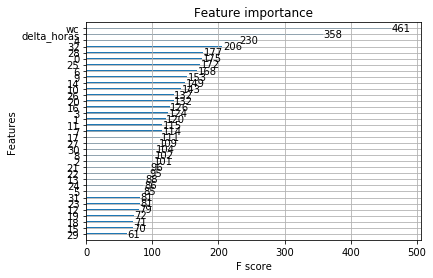

In [275]:
df_extra=respuestas_etiquetas[['delta_horas', 'wc']]

features_menos_i=features.toarray()
pca=TruncatedSVD(n_components=a)
pca=pca.fit(features_menos_i)
features_menos_i=pca.transform(features_menos_i)
Xall=pd.DataFrame(features_menos_i)
Xall=pd.concat([Xall,pd.DataFrame(df_extra.reset_index(drop=True))],axis=1)


clasificador=XGBClassifier()
clasificador=clasificador.fit(X=Xall,y=x_target)

from xgboost import plot_importance

plot_importance(clasificador)

### Parts of speech

In [194]:
import spacy
nlp=spacy.load('es')

In [195]:
pos=pd.DataFrame()
punct_all=[]
for a in range(0, respuestas_etiquetas.shape[0]):
    sent=nlp(respuestas_etiquetas.texto.values[a])
    schema=[]
    punct=[]
    for i in range(0, len(sent)):
        schema.append(sent[i].pos_)
        punct.append(sent[i].is_punct)
    schema=pd.DataFrame(dict((x,schema.count(x)) for x in set(schema)), index=[a])
    pos=pd.concat([pos, schema])
    punct=np.array(punct).sum()
    punct_all.append(punct)

In [196]:
punct_all=pd.DataFrame({'n_punct':punct_all})

In [197]:

pos=pd.concat([pos, punct_all], axis=1)

In [198]:
pos=pos.fillna(0)
pos=pos[pos.columns[pos.describe().loc['mean']>0.6]]

In [200]:
#pos

In [201]:
#pos=pos.div(respuestas_etiquetas.wc, axis=0)

In [202]:

respuestas_etiquetas=pd.concat([respuestas_etiquetas, pos], axis=1)

In [203]:
respuestas_etiquetas.head()

,id_contacto,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem,ADJ,ADP,ADV,AUX,CONJ,DET,NOUN,PRON,PROPN,PUNCT,SCONJ,VERB,n_punct
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,0.000000,18,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra,0,0,la solicitud de envi el sms por cobr a ha expi...,2.0,5.0,2.0,1.0,0.0,3.0,5.0,0.0,2.0,2.0,1.0,3.0,2
1,313822ff-7541-4db6-8fe1-a252363000ab,p_labor_w36_d7,prueba_fb,4.523333,18,+522461582793,sarahi,all altopd,135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra,0,0,te llam y no pud localizart tramit en line tu ...,0.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,6.0,2.0,0.0,4.0,2
2,86962a26-c021-4606-8986-893834ad83bd,uncaught,prueba_fb,675.067222,18,+524271210385,NaN,all altopd,5,modelo,59508,59508,1,informacion,informacion,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,b_reminders_w9_d4,prueba_fb,2.523056,18,+524271654479,NaN,all altopd,7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento,0,0,mi beb,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,b_reto_w26_d1,prueba_fb,2.523889,18,+522411259330,NaN,all altopd,99,modelo,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,18,respuesta,respuesta,0,0,si ya cad integr ten fot con la bb segu nos to...,2.0,1.0,1.0,0.0,1.0,3.0,6.0,1.0,0.0,0.0,1.0,2.0,0


In [204]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar)(i, 33,respuestas_etiquetas[['wc', 'hora_ultimo',
                                                                                     'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'NOUN',
       'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

0:05:50.988100


In [205]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [207]:
loo_predict_proba.head()

,id_contacto,flujo_penultimo,flujo_ultimo,delta_horas,hora_ultimo,urn,nombre_contacto,listas,cc,result,texto,texto_proc,wc,categ_opi,categ_final,n_interrogacion,es,texto_proc_stem,ADJ,ADP,ADV,AUX,CONJ,DET,NOUN,PRON,PROPN,PUNCT,SCONJ,VERB,n_punct,0,0,1,2,3,4,5,6,7,8
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,uncaught,miAlta_General,0,18,20999,NaN,NaN,144,modelo,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,24,otra,otra,0,0,la solicitud de envi el sms por cobr a ha expi...,2,5,2,1,0,3,5,0,2,2,1,3,2,0,0.703422,0.134371,0.002365,0.007140,0.003231,0.061887,0.009812,0.075381,0.002392
1,313822ff-7541-4db6-8fe1-a252363000ab,p_labor_w36_d7,prueba_fb,4.52333,18,+522461582793,sarahi,all altopd,135,modelo,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,24,otra,otra,0,0,te llam y no pud localizart tramit en line tu ...,0,3,2,1,2,1,2,1,6,2,0,4,2,0,0.755099,0.038237,0.004244,0.003577,0.001354,0.040416,0.021233,0.132062,0.003777
2,86962a26-c021-4606-8986-893834ad83bd,uncaught,prueba_fb,675.067,18,+524271210385,NaN,all altopd,5,modelo,59508,59508,1,informacion,informacion,0,0,,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0.417234,0.008361,0.001646,0.537664,0.000767,0.024075,0.002977,0.006464,0.000814
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,b_reminders_w9_d4,prueba_fb,2.52306,18,+524271654479,NaN,all altopd,7,modelo,Mi bebe,mi bebe,2,nacimiento,nacimiento,0,0,mi beb,0,0,0,0,0,1,0,0,0,0,0,1,0,2,0.037721,0.011224,0.791874,0.008572,0.126268,0.013615,0.003676,0.005034,0.002016
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,b_reto_w26_d1,prueba_fb,2.52389,18,+522411259330,NaN,all altopd,99,modelo,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,18,respuesta,respuesta,0,0,si ya cad integr ten fot con la bb segu nos to...,2,1,1,0,1,3,6,1,0,0,1,2,0,0,0.721630,0.033157,0.001155,0.004543,0.001248,0.159968,0.007804,0.067012,0.003483


In [208]:
loo_predict_proba.columns=[    'id_contacto', 'flujo_penultimo',    'flujo_ultimo',
           'delta_horas',     'hora_ultimo',             'urn',
       'nombre_contacto',          'listas',              'cc',
                'result',           'texto',      'texto_proc',
                    'wc',       'categ_opi',     'categ_final',
       'n_interrogacion',              'es', 'texto_proc_stem',
                   'ADJ',             'ADP',             'ADV',
                   'AUX',            'CONJ',             'DET',
                  'NOUN',            'PRON',           'PROPN',
                 'PUNCT',           'SCONJ',            'VERB',
               'n_punct',           'pred_loo',                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                       7,                 8]

In [209]:
f1_score(loo_predict_proba['pred_loo'], x_target, average='micro')

0.594111461619348

In [281]:
loo_predict_proba['pred_loo_mod']=loo_predict_proba['pred_loo']
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='otra_queja']='otra'
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='pregunta_busca trabajo']='pregunta'
loo_predict_proba['pred_loo_mod'].loc[loo_predict_proba['pred_loo_mod']=='pregunta_medica']='pregunta'

loo_predict_proba['categ_opi_mod']=loo_predict_proba['categ_opi']
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='otra_queja']='otra'
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='pregunta_busca trabajo']='pregunta'
loo_predict_proba['categ_opi_mod'].loc[loo_predict_proba['categ_opi_mod']=='pregunta_medica']='pregunta'

/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [282]:
pd.crosstab(loo_predict_proba['pred_loo_mod'], loo_predict_proba['categ_opi_mod'])

categ_opi_mod,emergencia,informacion,nacimiento,otra,pregunta,respuesta
pred_loo_mod,,,,,,
informacion,0,6,0,3,4,0
nacimiento,1,0,6,0,0,0
otra,3,14,0,264,79,29
pregunta,2,27,0,118,328,0
respuesta,0,1,1,39,2,47


In [283]:
(loo_predict_proba['pred_loo_mod']==loo_predict_proba['categ_opi_mod']).mean()


0.66837782340862428

In [286]:
loo_predict_proba.to_csv('./datos/loo_67.csv')

In [284]:
from sklearn.metrics import classification_report
print(classification_report(loo_predict_proba['pred_loo_mod'], loo_predict_proba['categ_opi_mod']))

             precision    recall  f1-score   support

 emergencia       0.00      0.00      0.00         0
informacion       0.12      0.46      0.20        13
 nacimiento       0.86      0.86      0.86         7
       otra       0.62      0.68      0.65       389
   pregunta       0.79      0.69      0.74       475
  respuesta       0.62      0.52      0.57        90

avg / total       0.70      0.67      0.68       974



/Users/pepe_opi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [201]:
#loo_predict_proba[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

loo_predict_proba.categ_final.value_counts()

5    337
0    279
7    145
3     76
6     58
1     48
8     18
2      7
4      6
Name: categ_final, dtype: int64

In [232]:
vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.047069,0.081138,0.153531,0.291391,-0.152267,-0.213585,0.410336,-0.154152,-0.143451,0.076189,0.115509,0.299091,0.189024,0.031803,-0.050113,0.139061,0.162284,0.108374,0.071265,-0.144001,-0.350386,0.130664,0.071516,0.147849,0.013135,0.008751,0.127702,0.020766,0.150149,0.207352,-0.094315,0.025707,-0.372840,-0.069726,-0.014611,-0.146902,0.032884,0.154955,0.044600,0.118447,0.157564,-0.083927,-0.174046,-0.271082,0.034551,0.109118,0.241647,-0.104356,0.004637,-0.118482,-0.204105,-0.202478,0.075702,0.045551,-0.109057,-0.288899,-0.114930,-0.046662,0.072428,0.047097,0.066139,0.064119,0.080348,0.032129,0.072381,0.117085,-0.181884,-0.150817,-0.277865,0.208445,-0.042767,0.024123,0.092775,-0.051282,-0.049429,-0.203792,0.041483,-0.048401,0.068396,-0.199445,-0.116534,0.098603,0.019283,0.072451,-0.171825,0.071276,-0.163929,-0.139247,-0.089273,0.090775,0.040555,-0.009565,0.213378,-0.061950,-0.270810,0.204409,0.074361,-0.077727,0.104851,-0.170915
1,0.108803,0.137789,0.004451,0.094429,0.148543,-0.212582,0.237387,-0.169919,-0.059051,-0.109385,0.076377,0.005678,-0.065343,-0.002456,0.102936,0.064315,-0.095027,0.141714,-0.089922,-0.007010,-0.403562,-0.035354,-0.172887,0.027589,-0.083082,-0.023426,0.059065,-0.135262,0.258510,0.350186,0.063996,0.035611,-0.254378,-0.096234,-0.154232,0.068115,0.115443,0.133768,0.142512,0.301023,-0.005220,-0.168080,-0.159538,-0.163282,0.141108,0.229686,0.104291,-0.231040,-0.032271,-0.199048,-0.337585,-0.244972,0.152691,-0.013546,0.069860,0.130669,0.027907,-0.179670,0.176373,-0.037085,0.074463,-0.031897,0.032794,-0.086205,0.244621,0.185763,0.028792,0.039281,-0.410611,0.134018,0.014997,-0.044642,0.073920,0.017248,0.150019,-0.241630,-0.020512,0.004928,-0.026793,-0.014375,0.067218,-0.055278,-0.051273,-0.047484,-0.116093,0.254242,-0.180724,-0.183234,0.010394,-0.131850,0.050164,0.000736,0.059818,-0.101425,-0.165128,0.188340,0.087580,-0.102862,0.022218,0.094265
2,0.000488,0.002152,0.001028,0.000449,-0.000763,0.001459,-0.000624,0.003918,0.004637,-0.001166,0.002917,0.000289,0.000680,0.004256,-0.004290,-0.004129,-0.004798,0.003326,0.002782,0.003700,0.004786,0.002992,-0.000385,0.002805,-0.003817,0.001399,-0.003566,0.004447,0.000218,-0.000853,-0.002354,0.002742,-0.000438,0.000684,-0.004812,0.001176,0.001121,0.001169,0.004437,0.001818,-0.001405,-0.000630,0.001976,-0.004398,0.001668,0.001706,-0.002896,-0.003711,-0.001846,-0.001363,0.000702,-0.000614,0.004884,-0.003980,-0.002911,-0.003387,0.001531,-0.002467,-0.000337,-0.002556,-0.003410,-0.003896,0.001563,-0.003618,-0.003034,-0.001313,0.003210,-0.004029,0.003379,-0.004039,0.004765,-0.000313,0.004768,0.001048,0.002393,-0.004608,-0.002172,-0.003798,-0.002039,-0.003813,-0.001820,-0.000857,-0.004359,0.001925,0.000666,-0.002346,0.000232,-0.004061,0.000759,0.004293,-0.001814,0.001674,-0.003682,0.002163,-0.002106,-0.003168,0.000865,-0.004799,0.003289,-0.004953
3,0.041283,0.086206,-0.140835,-0.027046,0.036961,-0.144458,0.045581,0.012983,0.091056,0.006241,0.089645,0.053688,0.048379,0.010476,-0.064821,0.069075,-0.097156,-0.064189,-0.013894,-0.010346,-0.114236,-0.038558,-0.055925,0.126930,-0.056857,0.088843,0.106686,-0.049766,0.089528,0.180437,0.076648,0.030073,-0.072698,0.004459,-0.094835,0.035766,0.062692,0.025692,0.025707,0.064107,-0.018397,0.008392,0.050391,0.009149,-0.000963,0.055511,-0.130164,-0.113713,-0.047435,-0.125663,-0.088877,0.017872,-0.019852,0.158746,-0.036088,0.075432,0.084270,-0.124508,0.018090,0.060220,-0.029834,0.003323,-0.089824,0.024599,0.085421,0.056739,0.195047,-0.058574,-0.160656,-0.024021,-0.006750,0.026885,0.090183,0.037221,0.115675,-0.061092,0.040848,0.004772,0.146109,0.063088,0.024564,-0.050470,-0.013265,0.012747,-0.039703,0.014723,0.060473,-0.095932,-0.048993,-0.079730,-0.006290,-

In [233]:
tsne_fit=tsne.fit_transform(vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]])

In [234]:
tsne_fit=pd.concat([vec[['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem']],  pd.DataFrame(tsne_fit)], axis=1)

tsne_fit=pd.concat([respuestas_etiquetas['categ_opi'], pd.DataFrame(tsne_fit)], axis=1)

In [235]:
tsne_fit.head()

,categ_opi,id_contacto,texto,texto_proc,texto_proc_stem,0,1
indice,,,,,,,
0,otra,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,la solicitud de envi el sms por cobr a ha expi...,-9.364109,13.262014
1,otra,313822ff-7541-4db6-8fe1-a252363000ab,Te llame y no pude localizarte. Tramita en lin...,te llame y no pude localizarte tramita en line...,te llam y no pud localizart tramit en line tu ...,-11.537829,17.337954
2,informacion,86962a26-c021-4606-8986-893834ad83bd,59508,59508,,-26.511097,-2.401554
3,nacimiento,84b7624f-261d-44b4-83ba-6fade1a44c3a,Mi bebe,mi bebe,mi beb,-4.417261,-11.748837
4,respuesta,e083b2ea-6e2d-410c-b5a4-8067a818d485,Hola si ya cada integrante tenemos fotos con l...,si ya cada integrante tenemos fotos con la bb...,si ya cad integr ten fot con la bb segu nos to...,5.294932,-3.083102


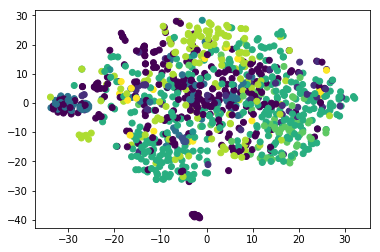

In [236]:
plt.scatter(tsne_fit[0],tsne_fit[1], c=tsne_fit.categ_opi.factorize()[0] )

In [278]:
def loo_masvar_2vec(i,df_extra):
    df_extra_orig=df_extra
    features_i=vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].loc[i]
    
    features_i=pd.concat([pd.DataFrame(features_i).transpose(),pd.DataFrame(df_extra.loc[i]).transpose()], axis=1)
    Xall=vec[vec.columns[np.invert(vec.columns.isin( ['id_contacto',           'texto',      'texto_proc',
       'texto_proc_stem',              'wc',       'categ_opi',
       'n_interrogacion']))]].drop(i, axis=0)
        
    Xall=pd.concat([Xall,pd.DataFrame(df_extra_orig.drop(i, axis=0))],axis=1)
    loo_predict_proba=pd.DataFrame()
        
    X_i=features_i
    Xall_one_out=Xall
    x_target_one_out=pd.DataFrame(x_target).drop(i, axis=0)
    clasificador=XGBClassifier(metrics='auc')
    
    clasificador=clasificador.fit(X=Xall_one_out,y=x_target_one_out['categ_opi'].ravel())
    pred=clasificador.predict(X_i)
    pred_proba=clasificador.predict_proba(X_i)
    loo_predict_proba_i=pd.concat([pd.DataFrame(respuestas_etiquetas.loc[i]).transpose(),
                                          pd.DataFrame(pred, index=[i]), pd.DataFrame(pred_proba, index=[i]),
                                         ], axis=1)
    loo_predict_proba=pd.concat([loo_predict_proba, loo_predict_proba_i])
    return(loo_predict_proba)

In [280]:
inicio=datetime.now()

loo_predict_proba=Parallel(n_jobs=-1)(delayed(loo_masvar_2vec)(i, respuestas_etiquetas[['wc', 'hora_ultimo']] ) for i in respuestas_etiquetas.index)

fin=datetime.now()

print(fin-inicio)

KeyboardInterrupt: 

In [241]:
loo_predict_proba=pd.concat(loo_predict_proba)

In [273]:
precision=f1_score(y_pred=loo_predict_proba.iloc[:, 68],y_true= x_target, average='micro')
print(precision)

0.5523613963039015


In [274]:
pd.crosstab(loo_predict_proba.iloc[:, 68], x_target)

categ_opi,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,pregunta_medica,respuesta
0,,,,,,,,,
informacion,0,1,0,2,0,4,0,0,0
nacimiento,1,0,2,1,0,0,0,0,0
otra,2,24,2,164,35,54,6,6,32
otra_queja,2,0,0,15,69,19,2,3,1
pregunta,1,20,0,68,40,246,33,9,4
pregunta_busca trabajo,0,0,0,2,1,12,17,0,0
respuesta,0,3,3,27,0,2,0,0,39
